In [2]:
from lerobot.datasets.lerobot_dataset import LeRobotDataset

ds = LeRobotDataset(repo_id="Themistoflix/ginger_back119ep")


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

meta/episodes/chunk-000/file-000.parquet:   0%|          | 0.00/253k [00:00<?, ?B/s]

meta/tasks.parquet:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

stats.json: 0.00B [00:00, ?B/s]

info.json: 0.00B [00:00, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

videos/observation.images.top/chunk-000/(…):   0%|          | 0.00/208M [00:00<?, ?B/s]

videos/observation.images.front/chunk-00(…):   0%|          | 0.00/204M [00:00<?, ?B/s]

videos/observation.images.top/chunk-000/(…):   0%|          | 0.00/90.3M [00:00<?, ?B/s]

videos/observation.images.top/chunk-000/(…):   0%|          | 0.00/206M [00:00<?, ?B/s]

videos/observation.images.front/chunk-00(…):   0%|          | 0.00/120M [00:00<?, ?B/s]

data/chunk-000/file-000.parquet:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

videos/observation.images.top/chunk-000/(…):   0%|          | 0.00/69.3M [00:00<?, ?B/s]

videos/observation.images.top/chunk-000/(…):   0%|          | 0.00/210M [00:00<?, ?B/s]

videos/observation.images.top/chunk-000/(…):   0%|          | 0.00/29.1M [00:00<?, ?B/s]

videos/observation.images.top/chunk-000/(…):   0%|          | 0.00/204M [00:00<?, ?B/s]

videos/observation.images.top/chunk-000/(…):   0%|          | 0.00/23.0M [00:00<?, ?B/s]

In [11]:
# Check dataset info
print(f"Total frames in dataset: {len(ds)}")
print(f"Number of episodes: {ds.meta.total_episodes}")
print(f"Video keys: {ds.meta.video_keys}")

# Look at episode info
print("\nEpisode info:")
for i in range(min(5, ds.meta.total_episodes)):
    ep_info = ds.meta.episodes[i]
    print(f"  Episode {i}: {ep_info}")


Total frames in dataset: 48240
Number of episodes: 119
Video keys: ['observation.images.front', 'observation.images.top']

Episode info:
  Episode 0: {'episode_index': 0, 'tasks': ['Place box on plate'], 'length': 721, 'data/chunk_index': 0, 'data/file_index': 0, 'dataset_from_index': 0, 'dataset_to_index': 721, 'videos/observation.images.front/chunk_index': 0, 'videos/observation.images.front/file_index': 0, 'videos/observation.images.front/from_timestamp': 0.0, 'videos/observation.images.front/to_timestamp': 24.033333333333335, 'videos/observation.images.top/chunk_index': 0, 'videos/observation.images.top/file_index': 1, 'videos/observation.images.top/from_timestamp': 0.0, 'videos/observation.images.top/to_timestamp': 24.033333333333335, 'meta/episodes/chunk_index': 0, 'meta/episodes/file_index': 0}
  Episode 1: {'episode_index': 1, 'tasks': ['Place box on plate'], 'length': 535, 'data/chunk_index': 0, 'data/file_index': 0, 'dataset_from_index': 721, 'dataset_to_index': 1256, 'videos

In [43]:
import torch
from lerobot.datasets.video_utils import decode_video_frames

def _query_videos(query_timestamps: dict[str, list[float]], ep_idx: int) -> dict[str, torch.Tensor]:
    """Note: When using data workers (e.g. DataLoader with num_workers>0), do not call this function
    in the main process (e.g. by using a second Dataloader with num_workers=0). It will result in a
    Segmentation Fault. This probably happens because a memory reference to the video loader is created in
    the main process and a subprocess fails to access it.
    """
    ep = ds.meta.episodes[ep_idx]
    item = {}
    for vid_key, query_ts in query_timestamps.items():
        print(f"query_ts: {query_ts}, vid_key: {vid_key}, ep: {ep}")
        # Episodes are stored sequentially on a single mp4 to reduce the number of files.
        # Thus we load the start timestamp of the episode on this mp4 and,
        # shift the query timestamp accordingly.
        from_timestamp = ep[f"videos/{vid_key}/from_timestamp"]
        print(f"from_timestamp: {from_timestamp}")
        shifted_query_ts = [from_timestamp + ts for ts in query_ts]

        video_path = ds.root / ds.meta.get_video_file_path(ep_idx, vid_key)

        print(f"video_path: {video_path}, shifted_query_ts: {shifted_query_ts}, ds.tolerance_s: {ds.tolerance_s}, ds.video_backend: {ds.video_backend}")
        frames = decode_video_frames(video_path, shifted_query_ts, ds.tolerance_s, ds.video_backend)
        item[vid_key] = frames.squeeze(0)

    return item

idx = 150

# Ensure dataset is loaded when we actually need to read from it
ds._ensure_hf_dataset_loaded()
item = ds.hf_dataset[idx]
ep_idx = item["episode_index"].item()

query_indices = None
if ds.delta_indices is not None:
    query_indices, padding = ds._get_query_indices(idx, ep_idx)
    query_result = ds._query_hf_dataset(query_indices)
    item = {**item, **padding}
    for key, val in query_result.items():
        item[key] = val

if len(ds.meta.video_keys) > 0:
    current_ts = item["timestamp"].item()

    print(f"current_ts: {current_ts}")
    query_timestamps = ds._get_query_timestamps(current_ts, query_indices)
    print(f"query_timestamps: {query_timestamps}")
    video_frames = _query_videos(query_timestamps, ep_idx)
    item = {**video_frames, **item}

current_ts: 5.0
query_timestamps: {'observation.images.front': [5.0], 'observation.images.top': [5.0]}
query_ts: [5.0], vid_key: observation.images.front, ep: {'episode_index': 0, 'tasks': ['Place box on plate'], 'length': 721, 'data/chunk_index': 0, 'data/file_index': 0, 'dataset_from_index': 0, 'dataset_to_index': 721, 'videos/observation.images.front/chunk_index': 0, 'videos/observation.images.front/file_index': 0, 'videos/observation.images.front/from_timestamp': 0.0, 'videos/observation.images.front/to_timestamp': 24.033333333333335, 'videos/observation.images.top/chunk_index': 0, 'videos/observation.images.top/file_index': 1, 'videos/observation.images.top/from_timestamp': 0.0, 'videos/observation.images.top/to_timestamp': 24.033333333333335, 'meta/episodes/chunk_index': 0, 'meta/episodes/file_index': 0}
from_timestamp: 0.0
video_path: /home/felix/.cache/huggingface/lerobot/Themistoflix/ginger_back119ep/videos/observation.images.front/chunk-000/file-000.mp4, shifted_query_ts: [5.

In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version (built with): {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")


PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA version (built with): 12.6
cuDNN version: 90501


In [28]:
[ds.meta.get_video_file_path(ep_idx, 'observation.images.top') for ep_idx in range(119)]

[PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-000/file-001.mp4'),
 PosixPath('videos/observation.images.top/chunk-

In [16]:
# Check actual video frame counts vs expected
from torchcodec.decoders import VideoDecoder
from pathlib import Path

# Get video files for some episodes and check their actual frame counts
print("Checking actual video frame counts vs metadata expectations:\n")

for ep_idx in range(min(10, ds.meta.total_episodes)):
    # Expected frames from metadata
    expected_frames = episode_to[ep_idx] - episode_from[ep_idx]
    
    # Get actual video file
    for vid_key in ds.meta.video_keys:
        video_path = ds.root / ds.meta.get_video_file_path(ep_idx, vid_key)
        if video_path.exists():
            decoder = VideoDecoder(str(video_path))
            actual_frames = len(decoder)
            match = "✓" if actual_frames == expected_frames else "✗ MISMATCH"
            print(f"Episode {ep_idx:3d} | {vid_key}: expected={expected_frames}, actual={actual_frames} {match}")
        else:
            print(f"Episode {ep_idx:3d} | {vid_key}: VIDEO FILE MISSING at {video_path}")


Checking actual video frame counts vs metadata expectations:

Episode   0 | observation.images.front: expected=721, actual=26792 ✗ MISMATCH
Episode   0 | observation.images.top: expected=721, actual=4193 ✗ MISMATCH
Episode   1 | observation.images.front: expected=535, actual=26792 ✗ MISMATCH
Episode   1 | observation.images.top: expected=535, actual=4193 ✗ MISMATCH
Episode   2 | observation.images.front: expected=472, actual=26792 ✗ MISMATCH
Episode   2 | observation.images.top: expected=472, actual=4193 ✗ MISMATCH
Episode   3 | observation.images.front: expected=528, actual=26792 ✗ MISMATCH
Episode   3 | observation.images.top: expected=528, actual=4193 ✗ MISMATCH
Episode   4 | observation.images.front: expected=410, actual=26792 ✗ MISMATCH
Episode   4 | observation.images.top: expected=410, actual=4193 ✗ MISMATCH
Episode   5 | observation.images.front: expected=419, actual=26792 ✗ MISMATCH
Episode   5 | observation.images.top: expected=419, actual=4193 ✗ MISMATCH
Episode   6 | observ

In [30]:
# Comprehensive check of ALL episodes to find all issues
print("Scanning ALL episodes for mismatches...\n")

mismatched_episodes = []
missing_videos = []

for ep_idx in range(ds.meta.total_episodes):
    expected_frames = episode_to[ep_idx] - episode_from[ep_idx]
    
    for vid_key in ds.meta.video_keys:
        video_path = ds.root / ds.meta.get_video_file_path(ep_idx, vid_key)
        if video_path.exists():
            try:
                decoder = VideoDecoder(str(video_path))
                actual_frames = len(decoder)
                if actual_frames != expected_frames:
                    mismatched_episodes.append({
                        'episode': ep_idx,
                        'video_key': vid_key,
                        'expected': expected_frames,
                        'actual': actual_frames,
                        'diff': actual_frames - expected_frames
                    })
            except Exception as e:
                print(f"Error reading episode {ep_idx} {vid_key}: {e}")
        else:
            missing_videos.append({'episode': ep_idx, 'video_key': vid_key, 'path': str(video_path)})

print(f"Total episodes: {ds.meta.total_episodes}")
print(f"Episodes with frame count mismatch: {len(mismatched_episodes)}")
print(f"Missing video files: {len(missing_videos)}")

if mismatched_episodes:
    print("\nMismatched episodes:")
    for m in mismatched_episodes[:20]:  # Show first 20
        print(f"  Episode {m['episode']:3d} | {m['video_key']}: expected={m['expected']}, actual={m['actual']} (diff={m['diff']})")
    if len(mismatched_episodes) > 20:
        print(f"  ... and {len(mismatched_episodes) - 20} more")


Scanning ALL episodes for mismatches...

Total episodes: 119
Episodes with frame count mismatch: 238
Missing video files: 0

Mismatched episodes:
  Episode   0 | observation.images.front: expected=721, actual=26792 (diff=26071)
  Episode   0 | observation.images.top: expected=721, actual=4193 (diff=3472)
  Episode   1 | observation.images.front: expected=535, actual=26792 (diff=26257)
  Episode   1 | observation.images.top: expected=535, actual=4193 (diff=3658)
  Episode   2 | observation.images.front: expected=472, actual=26792 (diff=26320)
  Episode   2 | observation.images.top: expected=472, actual=4193 (diff=3721)
  Episode   3 | observation.images.front: expected=528, actual=26792 (diff=26264)
  Episode   3 | observation.images.top: expected=528, actual=4193 (diff=3665)
  Episode   4 | observation.images.front: expected=410, actual=26792 (diff=26382)
  Episode   4 | observation.images.top: expected=410, actual=4193 (diff=3783)
  Episode   5 | observation.images.front: expected=419

In [18]:
# This was failing - let's try to access a safe index first
# ds[20000]  # This fails because video has fewer frames than metadata claims

# Try accessing an early index that should work
print("Trying to access index 0:")
sample = ds[0]
print(f"Sample keys: {sample.keys()}")

Trying to access index 0:
Sample keys: dict_keys(['observation.images.front', 'observation.images.top', 'action', 'observation.state', 'timestamp', 'frame_index', 'episode_index', 'index', 'task_index', 'task'])


In [19]:
# Find the maximum safe index based on actual video frame counts
# This tells us where the dataset is actually valid

if mismatched_episodes:
    # Get the first episode that's broken
    first_broken = min(m['episode'] for m in mismatched_episodes)
    
    # The safe range is up to the start of the first broken episode
    safe_max_idx = episode_from[first_broken] - 1
    
    print(f"First broken episode: {first_broken}")
    print(f"Safe index range: 0 to {safe_max_idx}")
    print(f"This means {safe_max_idx + 1} frames are safely accessible out of {len(ds)} reported")
else:
    print("No mismatches found - dataset appears consistent")


First broken episode: 0
Safe index range: 0 to -1
This means 0 frames are safely accessible out of 48240 reported


In [31]:
# Proper diagnostic: List ALL video files and analyze each one
from collections import defaultdict
from torchcodec.decoders import VideoDecoder
import os

# Group episodes by their video file for each camera
video_file_info = defaultdict(lambda: {
    'episodes': [], 
    'from_timestamps': [],
    'to_timestamps': [],
})

for ep_idx, ep in enumerate(episodes):
    for vid_key in ds.meta.video_keys:
        video_path = str(ds.root / ds.meta.get_video_file_path(ep_idx, vid_key))
        from_ts = ep[f"videos/{vid_key}/from_timestamp"]
        to_ts = ep[f"videos/{vid_key}/to_timestamp"]
        
        video_file_info[(vid_key, video_path)]['episodes'].append(ep_idx)
        video_file_info[(vid_key, video_path)]['from_timestamps'].append(from_ts)
        video_file_info[(vid_key, video_path)]['to_timestamps'].append(to_ts)

# Count files per camera
files_per_camera = defaultdict(list)
for (vid_key, path) in video_file_info.keys():
    files_per_camera[vid_key].append(path)

print("Video files per camera:")
for vid_key, paths in files_per_camera.items():
    print(f"  {vid_key}: {len(paths)} file(s)")
print()

# Analyze each video file
fps = ds.meta.fps
print("Detailed video file analysis:\n")

truncated_files = []
for (vid_key, path), info in sorted(video_file_info.items()):
    max_to_ts = max(info['to_timestamps'])
    min_from_ts = min(info['from_timestamps'])
    expected_frames = int(max_to_ts * fps)
    
    if os.path.exists(path):
        decoder = VideoDecoder(path)
        actual_frames = len(decoder)
        actual_duration = actual_frames / fps
        status = "✓" if actual_frames >= expected_frames else "✗ TRUNCATED"
        if actual_frames < expected_frames:
            truncated_files.append((vid_key, path, info, expected_frames, actual_frames))
    else:
        actual_frames = 0
        actual_duration = 0
        status = "✗ MISSING"
        truncated_files.append((vid_key, path, info, expected_frames, 0))
    
    print(f"{vid_key} | {os.path.basename(path)}")
    print(f"  Episodes {info['episodes'][0]}-{info['episodes'][-1]} ({len(info['episodes'])} eps)")
    print(f"  Timestamps: {min_from_ts:.2f}s to {max_to_ts:.2f}s")
    print(f"  Expected: {expected_frames} frames | Actual: {actual_frames} frames | {status}")
    print()


Video files per camera:
  observation.images.front: 2 file(s)
  observation.images.top: 4 file(s)

Detailed video file analysis:

observation.images.front | file-000.mp4
  Episodes 0-59 (60 eps)
  Timestamps: 0.00s to 893.07s
  Expected: 26792 frames | Actual: 26792 frames | ✓

observation.images.front | file-001.mp4
  Episodes 60-118 (59 eps)
  Timestamps: 0.00s to 1608.00s
  Expected: 48240 frames | Actual: 21448 frames | ✗ TRUNCATED

observation.images.top | file-001.mp4
  Episodes 0-29 (30 eps)
  Timestamps: 0.00s to 321.03s
  Expected: 9631 frames | Actual: 4193 frames | ✗ TRUNCATED

observation.images.top | file-003.mp4
  Episodes 30-59 (30 eps)
  Timestamps: 0.00s to 324.03s
  Expected: 9721 frames | Actual: 3247 frames | ✗ TRUNCATED

observation.images.top | file-005.mp4
  Episodes 60-88 (29 eps)
  Timestamps: 0.00s to 326.27s
  Expected: 9788 frames | Actual: 1936 frames | ✗ TRUNCATED

observation.images.top | file-007.mp4
  Episodes 89-118 (30 eps)
  Timestamps: 0.00s to 291.

In [32]:
# Find problematic episodes based on truncated video files
print("Summary of truncated/missing video files:\n")

if not truncated_files:
    print("✓ All video files have sufficient frames!")
    last_valid_episode = ds.meta.total_episodes - 1
else:
    # Build a map of video file -> actual frame count
    video_actual_frames = {}
    for (vid_key, path), info in video_file_info.items():
        if os.path.exists(path):
            decoder = VideoDecoder(path)
            video_actual_frames[(vid_key, path)] = len(decoder)
        else:
            video_actual_frames[(vid_key, path)] = 0
    
    # Find first broken episode
    first_broken_episode = None
    broken_reason = None
    
    for ep_idx, ep in enumerate(episodes):
        for vid_key in ds.meta.video_keys:
            video_path = str(ds.root / ds.meta.get_video_file_path(ep_idx, vid_key))
            to_ts = ep[f"videos/{vid_key}/to_timestamp"]
            actual_frames = video_actual_frames[(vid_key, video_path)]
            actual_duration = actual_frames / fps
            
            if to_ts > actual_duration + 0.01:  # small tolerance
                if first_broken_episode is None:
                    first_broken_episode = ep_idx
                    broken_reason = f"{vid_key} needs {to_ts:.2f}s but video only has {actual_duration:.2f}s"
                break
        if first_broken_episode is not None:
            break
    
    if first_broken_episode is not None:
        last_valid_episode = first_broken_episode - 1
        print(f"First broken episode: {first_broken_episode}")
        print(f"Reason: {broken_reason}")
    else:
        last_valid_episode = ds.meta.total_episodes - 1
        print("All episodes appear valid despite truncated files (timestamps within bounds)")

print(f"\n=== RESULT ===")
print(f"Last fully valid episode: {last_valid_episode}")
if last_valid_episode >= 0:
    safe_max_idx = episode_to[last_valid_episode] - 1
    print(f"Safe frame index range: 0 to {safe_max_idx}")
    print(f"Usable frames: {safe_max_idx + 1} out of {len(ds)} ({100*(safe_max_idx+1)/len(ds):.1f}%)")
    print(f"Usable episodes: {last_valid_episode + 1} out of {ds.meta.total_episodes}")
else:
    print("No valid episodes found!")


Summary of truncated/missing video files:

First broken episode: 8
Reason: observation.images.top needs 153.87s but video only has 139.77s

=== RESULT ===
Last fully valid episode: 7
Safe frame index range: 0 to 4172
Usable frames: 4173 out of 48240 (8.7%)
Usable episodes: 8 out of 119


In [33]:
# Test accessing valid vs invalid frames
print("Testing frame access...\n")

if last_valid_episode >= 0:
    # Test last valid frame
    test_idx = episode_to[last_valid_episode] - 1
    print(f"Accessing last valid frame (index {test_idx})...")
    try:
        sample = ds[test_idx]
        print(f"  ✓ Success! Got frame from episode {sample['episode_index'].item()}")
    except Exception as e:
        print(f"  ✗ Failed: {e}")
    
    # Test first invalid frame
    if last_valid_episode < ds.meta.total_episodes - 1:
        test_idx = episode_from[last_valid_episode + 1]
        print(f"\nAccessing first invalid frame (index {test_idx})...")
        try:
            sample = ds[test_idx]
            print(f"  Unexpectedly succeeded! Got frame from episode {sample['episode_index'].item()}")
        except Exception as e:
            print(f"  ✗ Failed as expected: {type(e).__name__}")


Testing frame access...

Accessing last valid frame (index 4172)...
  ✓ Success! Got frame from episode 7

Accessing first invalid frame (index 4173)...
  Unexpectedly succeeded! Got frame from episode 8


In [45]:
import matplotlib.pyplot as plt
import torch

def visualize_idx(dataset, idx: int):
    """Visualize the images at a given index in the dataset."""
    sample = dataset[idx]
    
    # Get video/image keys
    video_keys = dataset.meta.video_keys
    n_images = len(video_keys)
    
    fig, axes = plt.subplots(1, n_images, figsize=(6 * n_images, 6))
    if n_images == 1:
        axes = [axes]
    
    for ax, vid_key in zip(axes, video_keys):
        img_tensor = sample[vid_key]
        
        # Convert from (C, H, W) to (H, W, C) for matplotlib
        if img_tensor.dim() == 3 and img_tensor.shape[0] in [1, 3]:
            img = img_tensor.permute(1, 2, 0).numpy()
        else:
            img = img_tensor.numpy()
        
        # Normalize if needed (if values are 0-255, convert to 0-1)
        if img.max() > 1.0:
            img = img / 255.0
        
        ax.imshow(img)
        ax.set_title(f"{vid_key}\nidx={idx}, ep={sample['episode_index'].item()}, frame={sample['frame_index'].item()}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Also print other info
    print(f"Timestamp: {sample['timestamp'].item():.3f}s")
    print(f"Action: {sample['action'].tolist()}")
    print(f"State: {sample['observation.state'].tolist()}")


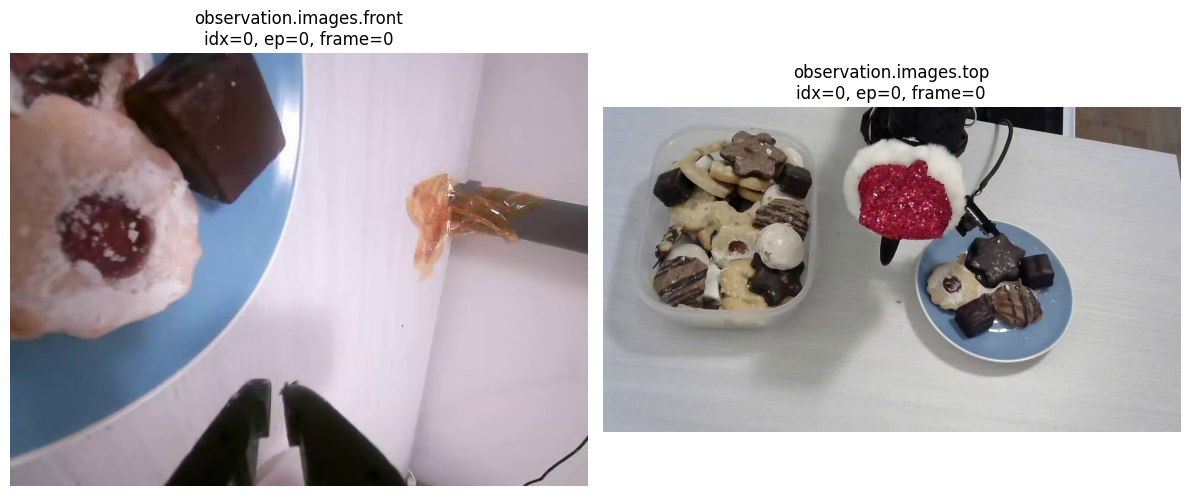

Timestamp: 0.000s
Action: [-15.2610445022583, -99.14893341064453, 99.90925598144531, 49.77777862548828, -3.487766742706299, 0.918196976184845]
State: [-15.007657051086426, -98.97611236572266, 99.54338073730469, 49.82517623901367, -3.3455305099487305, 1.1683849096298218]


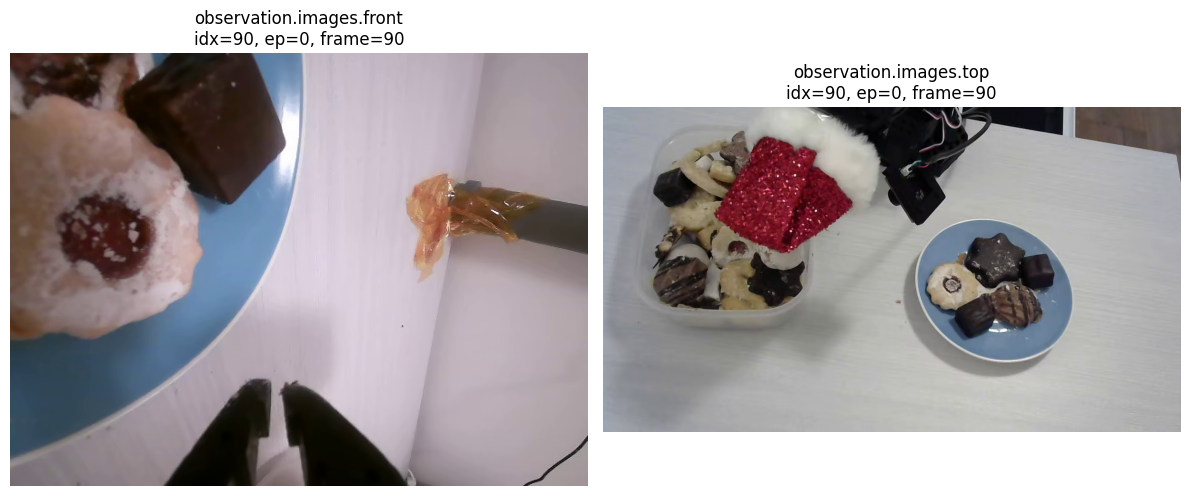

Timestamp: 3.000s
Action: [-15.2610445022583, -99.14893341064453, 99.90925598144531, 49.77777862548828, -3.487766742706299, 0.918196976184845]
State: [-15.007657051086426, -98.97611236572266, 99.54338073730469, 49.82517623901367, -3.3455305099487305, 1.1683849096298218]


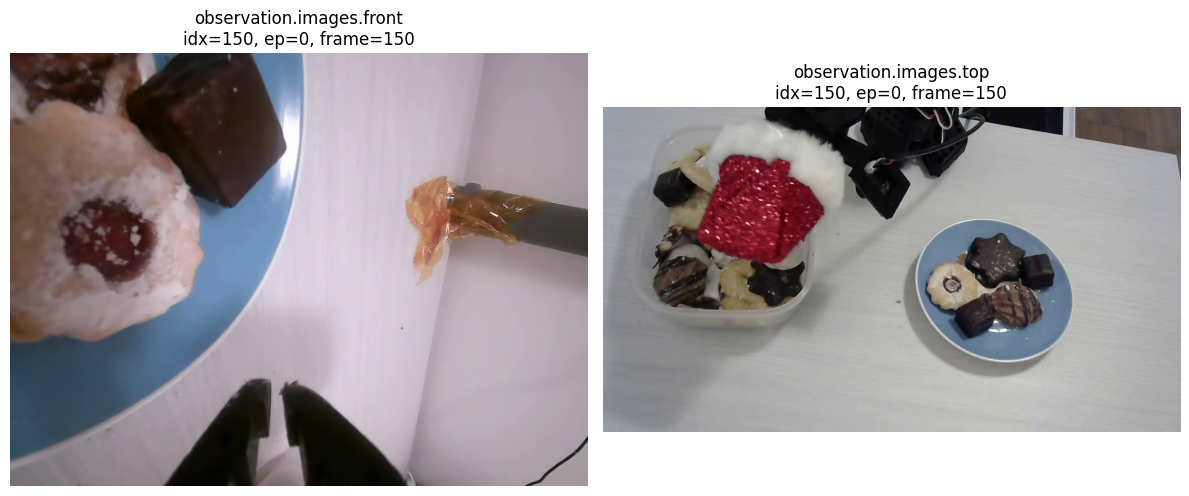

Timestamp: 5.000s
Action: [-15.341365814208984, -99.14893341064453, 99.90925598144531, 49.77777862548828, -3.643935441970825, 0.918196976184845]
State: [-15.23736572265625, -98.97611236572266, 99.54338073730469, 49.82517623901367, -3.3455305099487305, 1.1683849096298218]


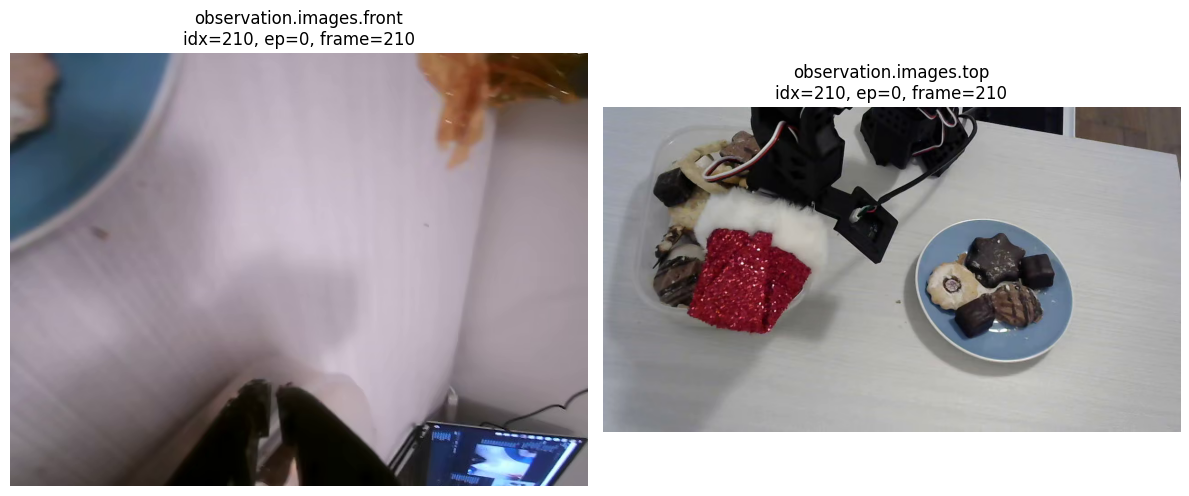

Timestamp: 7.000s
Action: [-1.847389578819275, -66.55319213867188, 65.15426635742188, 49.77777862548828, -3.3836543560028076, 0.33388981223106384]
State: [-2.7565083503723145, -70.05119323730469, 74.1552505493164, 49.82517623901367, -3.3978044986724854, 0.4810996651649475]


In [47]:
# Visualize a sample (use a valid index from episodes 0-7)
visualize_idx(ds, 0)
visualize_idx(ds, 90)
visualize_idx(ds, 150)
visualize_idx(ds, 210)